# Skill testing

- Models: ensemble average, reliability average, linear regression, delta method, NNGP, CNN
- Depths: l2 depth, linf depth, neighbor depth, 
- Shift: quantile corrected and uncorrected
- Variables: WN, TAS, TASMAX, PR

In [1]:
import os
import gc
import math

# numpy
import numpy as np
import scipy

# from jax
import jax
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.config import config
import jax.numpy as jnp
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

import haiku as hk
import flax
from flax import linen as nn
import optax

import properscoring as ps

config.update("jax_enable_x64", True)

# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter
plt.style.use('default')

from matplotlib.gridspec import GridSpec
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from matplotlib.gridspec import GridSpec
from matplotlib import colors
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

from tqdm.notebook import tqdm
from tqdm.notebook import trange

# netCDF
import netCDF4 as nc
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.ticker as tkr
from matplotlib.gridspec import GridSpec
from matplotlib import colors
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [3]:
def scale_and_split(xtrain, xtest, model_no, nval = 200):
    ytrain = xtrain[:,model_no]
    ytest = xtest[:,model_no]
    xtrain = np.delete(xtrain, model_no, axis=1)
    xtest = np.delete(xtest, model_no, axis=1)

    ## dimensions
    ntrain = xtrain.shape[0]
    ntest = xtest.shape[0]
    nlat = xtrain.shape[2]
    nlon = xtrain.shape[3]

    ## rescale
    xtrain_mean = np.mean(xtrain, axis = 1)
    xtest_mean = np.mean(xtest, axis = 1)
    xtrain_sd = np.std(xtrain, axis = 1)
    xtest_sd = np.std(xtest, axis = 1)

    xtrain_scaled = (xtrain - xtrain_mean[:,None]) / xtrain_sd[:,None]
    xtest_scaled = (xtest - xtest_mean[:,None]) / xtest_sd[:,None]
    ytrain_scaled = (ytrain - xtrain_mean) / xtrain_sd
    ytest_scaled = (ytest - xtest_mean) / xtest_sd

    xval_scaled = xtrain_scaled[-nval:]
    yval_scaled = ytrain_scaled[-nval:]
    xtrain_scaled = xtrain_scaled[:-nval]
    ytrain_scaled = ytrain_scaled[:-nval]
    
    out = [xtrain_scaled, xval_scaled, xtest_scaled,
            ytrain_scaled, yval_scaled, ytest_scaled,
            xtrain_mean, xtest_mean, xtrain_sd, xtest_sd]
    out = [np.float32(x) for x in out]
    return out

def anomalize(xtrain, xtest):
    xtrain_anom = np.zeros_like(xtrain)
    xtest_anom = np.zeros_like(xtest)

    ntrain = xtrain.shape[0]
    ntest = xtest.shape[0]

    monthly_means = np.array([np.mean(xtrain[(12*20):(12*50)][i::12], axis = 0) for i in range(12)])
    for k in trange(ntrain, leave = False):
        xtrain_anom[k] = xtrain[k] - monthly_means[k % 12]

    for k in trange(ntest, leave = False):
        xtest_anom[k] = xtest[k] - monthly_means[k % 12]
    
    return np.array(xtrain_anom), np.array(xtest_anom)

In [4]:
def inf_depth(x, y):
    dist = jnp.max(jnp.abs(y), axis = (1, 2))
    return 1/(1 + dist)
inf_depth = jit(inf_depth)

def global_mmd(x, y):
    dist = jnp.max(jnp.abs(x - y), axis = (1, 2))
    dist = jnp.mean(dist)
    return 1/(1 + dist)
global_mmd = jit(vmap(global_mmd, (None, 0)))

def global_mmd_self(x, y):
    dist = jnp.max(jnp.abs(x - y), axis = (1, 2))
    dist = jnp.mean(jnp.sort(dist)[1:])
    return 1/(1 + dist)
global_mmd_self = jit(vmap(global_mmd_self, (None, 0)))

def field_min(x, y):
    return jnp.min(jnp.array([x, y]))
field_min = jit(vmap(vmap(field_min, (0, 0)), (1, 1)))

def tukey_depth(x, y):
    fx_left = jnp.mean(x < y, axis = 0)
    fx_right = jnp.mean(x > y, axis = 0)
    return jnp.mean(2 * field_min(fx_left, fx_right))
tukey_depth = jit(vmap(tukey_depth, (None, 0)))

def tukey_depth_self(x, y):
    fx_left = jnp.sum(x < y, axis = 0)/(x.shape[0] - 1)
    fx_right = jnp.sum(x > y, axis = 0)/(x.shape[0] - 1)
    return jnp.mean(2 * field_min(fx_left, fx_right))
tukey_depth_self = jit(vmap(tukey_depth_self, (None, 0)))

def conformal_ensemble(resval, depth_fn, alpha):
    nval = resval.shape[0]
    level = np.ceil((1 - alpha) * (nval + 1))/(nval + 1)
    dr1 = 1 - depth_fn(resval, resval)
    q = np.sort(dr1)[int(np.ceil((1 - alpha) * (nval + 1)))]
    q = (q + np.quantile(dr1, level))/2
    return resval[dr1 < q]

In [5]:
def quantile_interp(model, model_quant, ref_quant):
    return jnp.interp(model, model_quant, ref_quant)
quantile_interp = vmap(quantile_interp, (1, 1, 1))
quantile_interp = vmap(quantile_interp, (1, 1, 1))
quantile_interp = jit(quantile_interp)

def quantile_map(ref, model_hist, model_future):
    ref_quant = jnp.quantile(ref, jnp.linspace(0, 1, 20), axis = 0)
    model_quant = jnp.quantile(model_hist, jnp.linspace(0, 1, 20), axis = 0)
    corrected_model = quantile_interp(model_future, model_quant, ref_quant)
    return jnp.moveaxis(corrected_model, 2, 0)
quantile_map = jit(quantile_map)

## Metrics

In [6]:
def slices(nlat, nlon, seed = 0):
    np.random.seed(seed)
    w = np.random.normal(0,1, [500, nlat*nlon])
    w = w / np.sqrt(np.sum(w**2, axis = 1))[:,None]
    return w

def sw2(x, y, w):
    x = x.reshape(-1, nlat*nlon)
    y = y.reshape(-1, nlat*nlon)
    
    x = x @ w.T
    y = y @ w.T
    
    qx = jnp.quantile(x, jnp.linspace(0, 1, 50), axis = 0)
    qy = jnp.quantile(y, jnp.linspace(0, 1, 50), axis = 0)
    return jnp.mean(jnp.sqrt(jnp.mean((qx - qy)**2, axis = 0)))

sw2 = jit(sw2)


def w2(x, y):
    qx = jnp.quantile(x, jnp.linspace(0.005, 0.995, 100), axis = 0)
    qy = jnp.quantile(y, jnp.linspace(0.005, 0.995, 100), axis = 0)
    return jnp.sqrt(jnp.mean((qx - qy)**2))

w2 = vmap(w2, (1, 1))
w2 = vmap(w2, (1, 1))
w2 = jit(w2)

def crps(ens, y): 
    lb = jnp.min(jnp.array([jnp.min(ens), jnp.min(y)]))
    ub = jnp.max(jnp.array([jnp.max(ens), jnp.max(y)]))
    cdf_a = jnp.array([jnp.mean(x > ens) for x in jnp.linspace(lb, ub, 50)])
    cdf_b = jnp.array([jnp.mean(x > y) for x in jnp.linspace(lb, ub, 50)])
    return jnp.sqrt(jnp.mean((cdf_a - cdf_b)**2))
crps = vmap(crps, (1, 1))
crps = vmap(crps, (1, 1))
crps = jit(crps)

def _pit(ensemble, y):
    pit = jnp.mean(jnp.array(ensemble[None,:] < y[:,None]).squeeze(), axis = 1)
    pit_cdf = jnp.array([jnp.mean(pit < x, axis = 0) for x in np.linspace(0, 1, 50)])
    uni_cdf = jnp.linspace(0, 1, 50)[:,None,None]
    pit_score = jnp.sqrt(jnp.mean((pit_cdf - uni_cdf)**2, axis = 0))
    return pit_score
pit = jit(_pit)

def boot(x):
    n = x.shape[0]
    idx = np.random.choice(n, n, replace = True)
    return x[idx]

def shuffle(x):
    n = x.shape[0]
    idx = np.random.choice(n, n, replace = False)
    return x[idx]

def moving_average(a, n=12):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def mse_weighted(x, y):
    nlat = x.shape[1]
    weight = np.cos(np.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
    weight /= np.mean(weight)
    weight = weight[None,:,None]
    
    return np.sqrt(np.mean((x - y)**2 * weight, axis = (1, 2)))

## Temperature (TAS)

In [7]:
# nproj = 6
# nval = 200

# xhist_tas = pickle.load(open('../data/xhist_tas_hr.pkl', 'rb'))
# xrcp_tas = pickle.load(open('../data/xrcp_tas_hr.pkl', 'rb'))
# nmod = xhist_tas.shape[1]
# nlat, nlon = xhist_tas[0].shape[1:]

# n = (2015 - 1940) * 12
# xhist_tas = xhist_tas[-n:]

# xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
# xtest_orig = xrcp_tas[108:]

# ntrain = xtrain_orig.shape[0] - nval
# ntest = xtest_orig.shape[0]

# save_loc = 'trained_models/tas'

# xtrain_anom, xtest_anom = anomalize(xtrain_orig, xtest_orig)
# xtrain_anom = jnp.array(xtrain_anom)
# xtest_anom = jnp.array(xtest_anom)
# del xtrain_orig, xtest_orig

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

In [50]:
# analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
# tas_results = np.zeros([nmod, nproj, 5, 8])
# w = slices(nlat, nlon)

# weight = jnp.cos(jnp.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
# weight = weight / jnp.mean(weight)
# weight = weight[None,:,None]
# weight = np.float32(weight)

# model_no = 1
# _data = scale_and_split(xtrain_anom, xtest_anom, model_no = model_no, nval = nval)

# xtrain = _data[0]
# xval = _data[1]
# xtest = _data[2]
# ytrain = _data[3]
# yval = _data[4]
# ytest = _data[5]
# xtrain_mean = _data[6]
# xtest_mean = _data[7]
# xtrain_sd = _data[8]
# xtest_sd = _data[9]

# ntrain = xtrain.shape[0]
# nval = xval.shape[0]
# ntest = xtest.shape[0]

# del _data

In [51]:
# k = 4
# yval_hat = np.load(save_loc + f'/yval_{analysis[k]}_{model_no}.npy')
# yval_hat = yval_hat.reshape(-1, nlat, nlon)
# ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}_{model_no}.npy')
# ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
# yval_hat = jnp.float32(jnp.array(yval_hat))
# ytest_hat = jnp.float32(jnp.array(ytest_hat))

# if analysis[k] == 'lm':
#     yval_hat = np.clip(yval_hat, -3, 3)
#     ytest_hat = np.clip(ytest_hat, -3, 3)

# xtrain2 = xtrain_sd[:-nval,None] * xtrain + xtrain_mean[:-nval,None]
# ytrain2 = xtrain_sd[:-nval] * ytrain + xtrain_mean[:-nval]

# yval2 = xtrain_sd[-nval:] * yval + xtrain_mean[-nval:]
# yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]

# xtest2 = xtest_sd[:,None] * xtest + xtest_mean[:,None]
# ytest2 = xtest_sd * ytest + xtest_mean
# ytest_hat = xtest_sd * ytest_hat + xtest_mean

# resval = yval2 - yval_hat
# restest = ytest2 - ytest_hat

# imv_ens = xtest2 - ytest_hat[:,None]

# qc_ens = jnp.array([quantile_map(ytrain2[-200:], xtrain2[-200:,j], xtest2[:,j]) for j in range(nmod-1)])
# qc_ens = np.moveaxis(qc_ens, 0, 1)
# qc_ens = qc_ens - ytest_hat[:,None]

# depth_fns = [global_mmd_self, tukey_depth_self, inf_depth]
# conf_ens1 = conformal_ensemble(resval, depth_fns[0], 0.1)
# conf_ens2 = conformal_ensemble(resval, depth_fns[1], 0.1)
# conf_ens3 = conformal_ensemble(resval, depth_fns[2], 0.1)

In [57]:
# cf_pit = pit(conf_ens1, restest)
# qc_pit = pit(qc_ens.reshape(-1, nlat, nlon), restest)
# imv_pit = pit(imv_ens.reshape(-1, nlat, nlon), restest)

# cf_crps = crps(conf_ens1, restest)
# qc_crps = crps(qc_ens.reshape(-1, nlat, nlon), restest)
# imv_crps = crps(imv_ens.reshape(-1, nlat, nlon), restest)

# cf_w2 = w2(conf_ens1, restest)
# qc_w2 = w2(qc_ens.reshape(-1, nlat, nlon), restest)
# imv_w2 = w2(imv_ens.reshape(-1, nlat, nlon), restest)

In [58]:
# def unitize(x):
#     a = (x - jnp.min(x))/(jnp.max(x) - jnp.min(x))
#     return 2*a - 1

# def unitize(x):
#     return x/jnp.std(x)

In [65]:
# top = plt.get_cmap('bone', 128)
# bottom = plt.get_cmap('gist_heat_r', 128)

# newcolors = np.vstack((top(np.linspace(0.0, 1, 100)),
#                        bottom(np.linspace(0, 1, 100))))
# newcmp = ListedColormap(newcolors)

# data_crs = ccrs.PlateCarree(central_longitude=180)
# plot_crs = ccrs.Robinson(central_longitude=180)

# fig = plt.figure(constrained_layout = True, figsize = (20, 8))
# gs = GridSpec(2, 3, figure = fig)

# ax = plt.subplot(gs[0, 0], projection=plot_crs)
# vmin, vcenter, vmax = -5, 0, 5
# divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# ax.imshow(unitize(cf_w2 - qc_w2), cmap = newcmp, transform = data_crs, norm = divnorm)
# ax.coastlines()

# ax = plt.subplot(gs[0, 1], projection=plot_crs)
# vmin, vcenter, vmax = -5, 0, 5
# divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# ax.imshow(unitize(cf_crps - qc_crps), cmap = newcmp, transform = data_crs, norm = divnorm)
# ax.coastlines()

# ax = plt.subplot(gs[0, 2], projection=plot_crs)
# vmin, vcenter, vmax = -5, 0, 5
# divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# ax.imshow(unitize(cf_pit - qc_pit), cmap = newcmp, transform = data_crs, norm = divnorm)
# ax.coastlines()

# ax = plt.subplot(gs[1, 0], projection=plot_crs)
# vmin, vcenter, vmax = -5, 0, 5
# divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# ax.imshow(unitize(cf_w2 - imv_w2), cmap = newcmp, transform = data_crs, norm = divnorm)
# ax.coastlines()

# ax = plt.subplot(gs[1, 1], projection=plot_crs)
# vmin, vcenter, vmax = -5, 0, 5
# divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# ax.imshow(unitize(cf_crps - imv_crps), cmap = newcmp, transform = data_crs, norm = divnorm)
# ax.coastlines()

# ax = plt.subplot(gs[1, 2], projection=plot_crs)
# vmin, vcenter, vmax = -5, 0, 5
# divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# ax.imshow(unitize(cf_pit - imv_pit), cmap = newcmp, transform = data_crs, norm = divnorm)
# ax.coastlines()

In [66]:
# top = plt.get_cmap('bone', 128)
# bottom = plt.get_cmap('gist_heat_r', 128)

# newcolors = np.vstack((top(np.linspace(0.0, 1, 100)),
#                        bottom(np.linspace(0, 1, 100))))
# newcmp = ListedColormap(newcolors)

# data_crs = ccrs.PlateCarree(central_longitude=180)
# plot_crs = ccrs.Robinson(central_longitude=180)

# fig = plt.figure(constrained_layout = True, figsize = (20, 8))
# gs = GridSpec(2, 3, figure = fig)

# ax = plt.subplot(gs[0, 0], projection=plot_crs)
# vmin, vcenter, vmax = -3, 0, 3
# divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# ax.imshow(cf_w2 - qc_w2, cmap = newcmp, transform = data_crs, norm = divnorm)
# ax.coastlines()


# ax = plt.subplot(gs[0, 1], projection=plot_crs)
# vmin, vcenter, vmax = -1, 0, 1
# divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# ax.imshow(cf_crps - qc_crps, cmap = newcmp, transform = data_crs, norm = divnorm)
# ax.coastlines()


# ax = plt.subplot(gs[0, 2], projection=plot_crs)
# vmin, vcenter, vmax = -1, 0, 1
# divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# ax.imshow(cf_pit - qc_pit, cmap = newcmp, transform = data_crs, norm = divnorm)
# ax.coastlines()


# ax = plt.subplot(gs[1, 0], projection=plot_crs)
# vmin, vcenter, vmax = -3, 0, 3
# divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# ax.imshow(cf_w2 - imv_w2, cmap = newcmp, transform = data_crs, norm = divnorm)
# ax.coastlines()


# ax = plt.subplot(gs[1, 1], projection=plot_crs)
# vmin, vcenter, vmax = -1, 0, 1
# divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# ax.imshow(cf_crps - imv_crps, cmap = newcmp, transform = data_crs, norm = divnorm)
# ax.coastlines()


# ax = plt.subplot(gs[1, 2], projection=plot_crs)
# vmin, vcenter, vmax = -1, 0, 1
# divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# ax.imshow(cf_pit - imv_pit, cmap = newcmp, transform = data_crs, norm = divnorm)
# ax.coastlines()

In [7]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_tas_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tas_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]
nlat, nlon = xhist_tas[0].shape[1:]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/tas'

xtrain_anom, xtest_anom = anomalize(xtrain_orig, xtest_orig)
xtrain_anom = jnp.array(xtrain_anom)
xtest_anom = jnp.array(xtest_anom)
del xtrain_orig, xtest_orig

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

In [69]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
nproj = len(analysis)
tas_results = np.zeros((nmod, nproj, 5, 2, nlat, nlon))

weight = jnp.cos(jnp.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
weight = weight / jnp.mean(weight)
weight = weight[None,:,None]
weight = np.float32(weight)

for model_no in trange(nmod):
    _data = scale_and_split(xtrain_anom, xtest_anom, model_no = model_no, nval = nval)

    xtrain = _data[0]
    xval = _data[1]
    xtest = _data[2]
    ytrain = _data[3]
    yval = _data[4]
    ytest = _data[5]
    xtrain_mean = _data[6]
    xtest_mean = _data[7]
    xtrain_sd = _data[8]
    xtest_sd = _data[9]

    ntrain = xtrain.shape[0]
    nval = xval.shape[0]
    ntest = xtest.shape[0]

    del _data
    
    for k in trange(0, nproj, leave = False):
        yval_hat = np.load(save_loc + f'/yval_{analysis[k]}_{model_no}.npy')
        yval_hat = yval_hat.reshape(-1, nlat, nlon)
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}_{model_no}.npy')
        ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
        yval_hat = jnp.float32(jnp.array(yval_hat))
        ytest_hat = jnp.float32(jnp.array(ytest_hat))
        
        if analysis[k] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)

        xtrain2 = xtrain_sd[:-nval,None] * xtrain + xtrain_mean[:-nval,None]
        ytrain2 = xtrain_sd[:-nval] * ytrain + xtrain_mean[:-nval]

        yval2 = xtrain_sd[-nval:] * yval + xtrain_mean[-nval:]
        yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]

        xtest2 = xtest_sd[:,None] * xtest + xtest_mean[:,None]
        ytest2 = xtest_sd * ytest + xtest_mean
        ytest_hat = xtest_sd * ytest_hat + xtest_mean

        resval = yval2 - yval_hat
        restest = ytest2 - ytest_hat

        imv_ens = xtest2 - ytest_hat[:,None]

        qc_ens = jnp.array([quantile_map(ytrain2[-200:], xtrain2[-200:,j], xtest2[:,j]) for j in range(nmod-1)])
        qc_ens = np.moveaxis(qc_ens, 0, 1)
        qc_ens = qc_ens - ytest_hat[:,None]

        depth_fns = [global_mmd_self, tukey_depth_self, inf_depth]
        conf_ens1 = conformal_ensemble(resval, depth_fns[0], 0.1)
        conf_ens2 = conformal_ensemble(resval, depth_fns[1], 0.1)
        conf_ens3 = conformal_ensemble(resval, depth_fns[2], 0.1)
        
        tas_results[model_no, k, 0, 0] = w2(imv_ens.reshape(-1, nlat, nlon), restest)
        tas_results[model_no, k, 1, 0] = w2(qc_ens.reshape(-1, nlat, nlon), restest)
        tas_results[model_no, k, 2, 0] = w2(conf_ens1, restest)
        tas_results[model_no, k, 3, 0] = w2(conf_ens2, restest)
        tas_results[model_no, k, 4, 0] = w2(conf_ens3, restest)
        tas_results[model_no, k, 0, 1] = crps(imv_ens.reshape(-1, nlat, nlon), restest)
        tas_results[model_no, k, 1, 1] = crps(qc_ens.reshape(-1, nlat, nlon), restest)
        tas_results[model_no, k, 2, 1] = crps(conf_ens1, restest)
        tas_results[model_no, k, 3, 1] = crps(conf_ens2, restest)
        tas_results[model_no, k, 4, 1] = crps(conf_ens3, restest)

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
# np.save('./tas_results_space', tas_results)
tas_results = np.load('./tas_results_space.npy')

In [9]:
# tas_results.shape

In [10]:
# imv_w2_diff = np.mean(tas_results[:,:,2,0] - tas_results[:,:,0,0], axis = (0, 1))
# qc_w2_diff = np.mean(tas_results[:,:,2,0] - tas_results[:,:,1,0], axis = (0, 1))
# imv_crps_diff = np.mean(tas_results[:,:,2,1] - tas_results[:,:,0,1], axis = (0, 1))
# qc_crps_diff = np.mean(tas_results[:,:,2,1] - tas_results[:,:,1,1], axis = (0, 1))

In [11]:
# top = plt.get_cmap('bone', 128)
# bottom = plt.get_cmap('gist_heat_r', 128)

# newcolors = np.vstack((top(np.linspace(0.0, 1, 100)),
#                        bottom(np.linspace(0, 1, 100))))
# newcmp = ListedColormap(newcolors)

# data_crs = ccrs.PlateCarree(central_longitude=180)
# plot_crs = ccrs.Robinson(central_longitude=180)

# fig = plt.figure(constrained_layout = True, figsize = (20, 8))
# gs = GridSpec(1, 4, figure = fig)

# ax = plt.subplot(gs[0, 0], projection=plot_crs)
# vmin, vcenter, vmax = -3, 0, 3
# divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# ax.imshow(imv_w2_diff, cmap = newcmp, transform = data_crs, norm = divnorm)
# ax.coastlines()

# ax = plt.subplot(gs[0, 1], projection=plot_crs)
# vmin, vcenter, vmax = -1.5, 0, 1.5
# divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# ax.imshow(qc_w2_diff, cmap = newcmp, transform = data_crs, norm = divnorm)
# ax.coastlines()

# ax = plt.subplot(gs[0, 2], projection=plot_crs)
# vmin, vcenter, vmax = -0.2, 0, 0.2
# divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# ax.imshow(imv_crps_diff, cmap = newcmp, transform = data_crs, norm = divnorm)
# ax.coastlines()

# ax = plt.subplot(gs[0, 3], projection=plot_crs)
# vmin, vcenter, vmax = -0.2, 0, 0.2
# divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# ax.imshow(qc_crps_diff, cmap = newcmp, transform = data_crs, norm = divnorm)
# ax.coastlines()


In [114]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_tasmax_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tasmax_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]
nlat, nlon = xhist_tas[0].shape[1:]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/tmax'

xtrain_anom, xtest_anom = anomalize(xtrain_orig, xtest_orig)
xtrain_anom = jnp.array(xtrain_anom)
xtest_anom = jnp.array(xtest_anom)
del xtrain_orig, xtest_orig

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/924 [00:00<?, ?it/s]

In [115]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
nproj = len(analysis)
tmax_results = np.zeros((nmod, nproj, 5, 2, nlat, nlon))

weight = jnp.cos(jnp.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
weight = weight / jnp.mean(weight)
weight = weight[None,:,None]
weight = np.float32(weight)

for model_no in trange(nmod):
    _data = scale_and_split(xtrain_anom, xtest_anom, model_no = model_no, nval = nval)

    xtrain = _data[0]
    xval = _data[1]
    xtest = _data[2]
    ytrain = _data[3]
    yval = _data[4]
    ytest = _data[5]
    xtrain_mean = _data[6]
    xtest_mean = _data[7]
    xtrain_sd = _data[8]
    xtest_sd = _data[9]

    ntrain = xtrain.shape[0]
    nval = xval.shape[0]
    ntest = xtest.shape[0]

    del _data
    
    for k in trange(0, nproj, leave = False):
        yval_hat = np.load(save_loc + f'/yval_{analysis[k]}_{model_no}.npy')
        yval_hat = yval_hat.reshape(-1, nlat, nlon)
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}_{model_no}.npy')
        ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
        yval_hat = jnp.float32(jnp.array(yval_hat))
        ytest_hat = jnp.float32(jnp.array(ytest_hat))
        
        if analysis[k] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)

        xtrain2 = xtrain_sd[:-nval,None] * xtrain + xtrain_mean[:-nval,None]
        ytrain2 = xtrain_sd[:-nval] * ytrain + xtrain_mean[:-nval]

        yval2 = xtrain_sd[-nval:] * yval + xtrain_mean[-nval:]
        yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]

        xtest2 = xtest_sd[:,None] * xtest + xtest_mean[:,None]
        ytest2 = xtest_sd * ytest + xtest_mean
        ytest_hat = xtest_sd * ytest_hat + xtest_mean

        resval = yval2 - yval_hat
        restest = ytest2 - ytest_hat

        imv_ens = xtest2 - ytest_hat[:,None]

        qc_ens = jnp.array([quantile_map(ytrain2[-200:], xtrain2[-200:,j], xtest2[:,j]) for j in range(nmod-1)])
        qc_ens = np.moveaxis(qc_ens, 0, 1)
        qc_ens = qc_ens - ytest_hat[:,None]

        depth_fns = [global_mmd_self, tukey_depth_self, inf_depth]
        conf_ens1 = conformal_ensemble(resval, depth_fns[0], 0.1)
        conf_ens2 = conformal_ensemble(resval, depth_fns[1], 0.1)
        conf_ens3 = conformal_ensemble(resval, depth_fns[2], 0.1)
        
        tmax_results[model_no, k, 0, 0] = w2(imv_ens.reshape(-1, nlat, nlon), restest)
        tmax_results[model_no, k, 1, 0] = w2(qc_ens.reshape(-1, nlat, nlon), restest)
        tmax_results[model_no, k, 2, 0] = w2(conf_ens1, restest)
        tmax_results[model_no, k, 3, 0] = w2(conf_ens2, restest)
        tmax_results[model_no, k, 4, 0] = w2(conf_ens3, restest)
        tmax_results[model_no, k, 0, 1] = crps(imv_ens.reshape(-1, nlat, nlon), restest)
        tmax_results[model_no, k, 1, 1] = crps(qc_ens.reshape(-1, nlat, nlon), restest)
        tmax_results[model_no, k, 2, 1] = crps(conf_ens1, restest)
        tmax_results[model_no, k, 3, 1] = crps(conf_ens2, restest)
        tmax_results[model_no, k, 4, 1] = crps(conf_ens3, restest)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
# np.save('./tmax_results_space', tmax_results)
tmax_results = np.load('./tmax_results_space.npy')

In [117]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_pr_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_pr_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]
nlat, nlon = xhist_tas[0].shape[1:]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

xtrain_orig = np.log(np.abs(xtrain_orig) + 1e-3)
xtest_orig = np.log(np.abs(xtest_orig) + 1e-3)

xtrain_orig = np.float32(xtrain_orig)
xtest_orig = np.float32(xtest_orig)

save_loc = 'trained_models/pr'

xtrain_anom, xtest_anom = anomalize(xtrain_orig, xtest_orig)
xtrain_anom = np.array(xtrain_anom)
xtest_anom = np.array(xtest_anom)
del xtrain_orig, xtest_orig

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

In [118]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
nproj = len(analysis)
pr_results = np.zeros((nmod, nproj, 5, 2, nlat, nlon))

weight = jnp.cos(jnp.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
weight = weight / jnp.mean(weight)
weight = weight[None,:,None]
weight = np.float32(weight)

for model_no in trange(nmod):
    _data = scale_and_split(xtrain_anom, xtest_anom, model_no = model_no, nval = nval)

    xtrain = _data[0]
    xval = _data[1]
    xtest = _data[2]
    ytrain = _data[3]
    yval = _data[4]
    ytest = _data[5]
    xtrain_mean = _data[6]
    xtest_mean = _data[7]
    xtrain_sd = _data[8]
    xtest_sd = _data[9]

    ntrain = xtrain.shape[0]
    nval = xval.shape[0]
    ntest = xtest.shape[0]

    del _data
    
    for k in trange(0, nproj, leave = False):
        yval_hat = np.load(save_loc + f'/yval_{analysis[k]}_{model_no}.npy')
        yval_hat = yval_hat.reshape(-1, nlat, nlon)
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}_{model_no}.npy')
        ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
        yval_hat = jnp.float32(jnp.array(yval_hat))
        ytest_hat = jnp.float32(jnp.array(ytest_hat))
        
        if analysis[k] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)

        xtrain2 = xtrain_sd[:-nval,None] * xtrain + xtrain_mean[:-nval,None]
        ytrain2 = xtrain_sd[:-nval] * ytrain + xtrain_mean[:-nval]

        yval2 = xtrain_sd[-nval:] * yval + xtrain_mean[-nval:]
        yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]

        xtest2 = xtest_sd[:,None] * xtest + xtest_mean[:,None]
        ytest2 = xtest_sd * ytest + xtest_mean
        ytest_hat = xtest_sd * ytest_hat + xtest_mean

        resval = yval2 - yval_hat
        restest = ytest2 - ytest_hat

        imv_ens = xtest2 - ytest_hat[:,None]

        qc_ens = jnp.array([quantile_map(ytrain2[-200:], xtrain2[-200:,j], xtest2[:,j]) for j in range(nmod-1)])
        qc_ens = np.moveaxis(qc_ens, 0, 1)
        qc_ens = qc_ens - ytest_hat[:,None]

        depth_fns = [global_mmd_self, tukey_depth_self, inf_depth]
        conf_ens1 = conformal_ensemble(resval, depth_fns[0], 0.1)
        conf_ens2 = conformal_ensemble(resval, depth_fns[1], 0.1)
        conf_ens3 = conformal_ensemble(resval, depth_fns[2], 0.1)
        
        pr_results[model_no, k, 0, 0] = w2(imv_ens.reshape(-1, nlat, nlon), restest)
        pr_results[model_no, k, 1, 0] = w2(qc_ens.reshape(-1, nlat, nlon), restest)
        pr_results[model_no, k, 2, 0] = w2(conf_ens1, restest)
        pr_results[model_no, k, 3, 0] = w2(conf_ens2, restest)
        pr_results[model_no, k, 4, 0] = w2(conf_ens3, restest)
        pr_results[model_no, k, 0, 1] = crps(imv_ens.reshape(-1, nlat, nlon), restest)
        pr_results[model_no, k, 1, 1] = crps(qc_ens.reshape(-1, nlat, nlon), restest)
        pr_results[model_no, k, 2, 1] = crps(conf_ens1, restest)
        pr_results[model_no, k, 3, 1] = crps(conf_ens2, restest)
        pr_results[model_no, k, 4, 1] = crps(conf_ens3, restest)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [13]:
# np.save('./pr_results_space', pr_results)
pr_results = np.load('./pr_results_space.npy')

In [14]:
# tas_results.shape

In [15]:
results = [tas_results, tmax_results, pr_results]

In [16]:
def vrange(x):
    _vmin = np.min(x)
    _vmax = np.max(x)
    vmin = 1.1*np.min([_vmin, -_vmax])
    vmax = 1.1*np.max([-_vmin, _vmax])
    return vmin, 0, vmax

In [ ]:
climate_vars = ['W2 Ratio:\nConf. / IMV', 
                'W2 Ratio:\nConf. / IMV (BC)', 
                'CRPS Ratio:\nConf. / IMV', 
                'CRPS Ratio:\nConf. / IMV (BC)']

top = plt.get_cmap('bone', 128)
bottom = plt.get_cmap('gist_heat_r', 128)

newcolors = np.vstack((top(np.linspace(0.0, 1, 100)), bottom(np.linspace(0, 1, 100))))
newcmp = ListedColormap(newcolors)

data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)

fig = plt.figure(constrained_layout = True, figsize = (22, 11))
gs = GridSpec(3, 5, width_ratios = [0.05, 1, 1, 1, 1], figure = fig)

# side labels
ax = plt.subplot(gs[0, 0])
ax.axis('off')
ax.text(0.0, 0.5, 'TAS', fontsize=26, va='center', rotation='vertical')

ax = plt.subplot(gs[1, 0])
ax.axis('off')
ax.text(0.0, 0.5, 'TMAX', fontsize=26, va='center', rotation='vertical')

ax = plt.subplot(gs[2, 0])
ax.axis('off')
ax.text(0.0, 0.5, 'PR', fontsize=26, va='center', rotation='vertical')

for i in range(3):
    imv_w2_diff = np.median(results[i][:,:,2,0] - results[i][:,:,0,0], axis = (0, 1))
    qc_w2_diff = np.median(results[i][:,:,2,0] - results[i][:,:,1,0], axis = (0, 1))
    imv_crps_diff = np.median(results[i][:,:,2,1] - results[i][:,:,0,1], axis = (0, 1))
    qc_crps_diff = np.median(results[i][:,:,2,1] - results[i][:,:,1,1], axis = (0, 1))
    diffs = [imv_w2_diff, qc_w2_diff, imv_crps_diff, qc_crps_diff]
    
    for j in range(1, 5):
        ax = plt.subplot(gs[i, j], projection=plot_crs)
        vmin, vcenter, vmax = vrange(diffs[j-1])
        divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
        im = ax.imshow(diffs[j-1], cmap = newcmp, transform = data_crs, norm = divnorm)
        ax.coastlines()
        cb = ax.figure.colorbar(im, ax=ax, location = 'bottom', 
                                extend = 'both', shrink = 0.8,
                                format = tkr.FormatStrFormatter('%.2f'))
        cb.ax.tick_params(labelsize=15)
        if i == 0:
            ax.set_title('' + climate_vars[j-1], fontsize = 24)

plt.show()

In [22]:
def vrange(x, a = 1.2):
    _vmin = np.min(x)
    _vmax = np.max(x)
    vmin = a*np.min([_vmin, -_vmax])
    vmax = a*np.max([-_vmin, _vmax])
    return vmin, 0, vmax

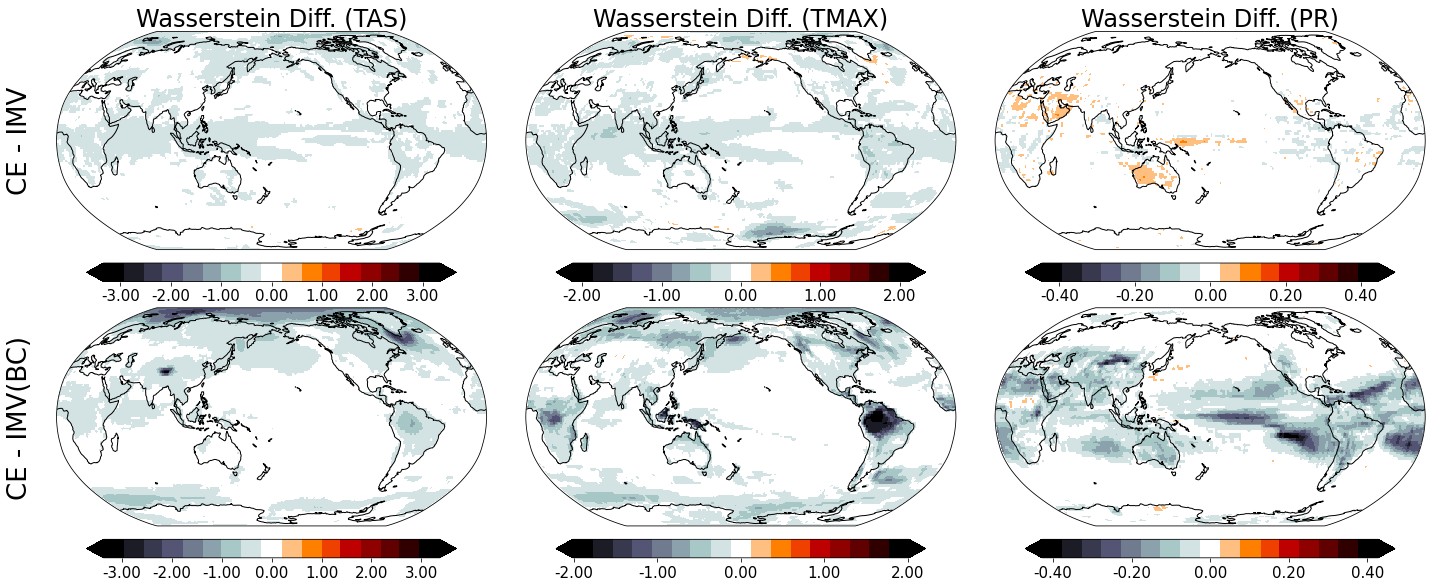

In [64]:
top = plt.get_cmap('bone', 9)
bottom = plt.get_cmap('gist_heat_r', 9)

newcolors = np.vstack((top(np.linspace(0, 0.945, 100)), bottom(np.linspace(0.055, 1, 100))))
newcmp = ListedColormap(newcolors)

data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)

fig = plt.figure(constrained_layout = True, figsize = (20, 8))
gs = GridSpec(2, 4, width_ratios = [0.05, 1, 1, 1], figure = fig)

# side labels
ax = plt.subplot(gs[0, 0])
ax.axis('off')
ax.text(0.0, 0.5, 'CE - IMV', fontsize=26, va='center', rotation='vertical')

ax = plt.subplot(gs[1, 0])
ax.axis('off')
ax.text(0.0, 0.5, 'CE - IMV(BC)', fontsize=26, va='center', rotation='vertical')


climate_vars = ['Wasserstein Diff. (TAS)', 'Wasserstein Diff. (TMAX)', 'Wasserstein Diff. (PR)']
amps = [[1, 1, 1], [2.5, 2, 3.5]]

for i in range(3):
    imv_w2_diff = np.median(results[i][:,:,2,0] - results[i][:,:,0,0], axis = (0, 1))
    qc_w2_diff = np.median(results[i][:,:,2,0] - results[i][:,:,1,0], axis = (0, 1))
    diffs = [imv_w2_diff, qc_w2_diff]
    
    for j in range(2):
        ax = plt.subplot(gs[j, 1+i], projection=plot_crs)
        vmin, vcenter, vmax = vrange(diffs[j], amps[j][i])
        divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
        im = ax.imshow(diffs[j-1], cmap = newcmp, transform = data_crs, norm = divnorm)
        ax.coastlines()
        
        cb = ax.figure.colorbar(im, ax=ax, location = 'bottom', 
                                extend = 'both', shrink = 0.8,
                                format = tkr.FormatStrFormatter('%.2f'))
        cb.ax.tick_params(labelsize=15)
        if j == 0:
            ax.set_title('' + climate_vars[i], fontsize = 24)

plt.show()

In [9]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
k = 4

yval_hat = np.load(save_loc + f'/yval_{analysis[k]}_{model_no}.npy')
ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}_{model_no}.npy')

if analysis[k] == 'lm':
    yval_hat = np.clip(yval_hat, -3, 3)
    ytest_hat = np.clip(ytest_hat, -3, 3)

yval_hat = yval_hat.reshape(-1, nlat, nlon)
ytest_hat = ytest_hat.reshape(-1, nlat, nlon)

yval_hat = yval_hat * xtrain_sd[-nval:]
ytest_hat = ytest_hat * xtest_sd
resval = (yval - yval_hat).reshape(-1, nlat, nlon)
restest = (ytest - ytest_hat).reshape(-1, nlat, nlon)

alpha = 0.1
level = np.ceil((1 - alpha) * (nval + 1))/(nval + 1)
dr1 = 1 - global_mmd_self(resval, resval)
q = np.sort(dr1)[int(np.ceil((1 - alpha) * (nval + 1)))]
q = (q + np.quantile(dr1, level))/2
conf_ens1 = resval[dr1 < q]

In [10]:
imv = np.array([vw2(imv_ens[(240*i):(240*(i+1))].reshape(-1, nlat, nlon), restest[(240*i):(240*(i+1))]) for i in range(4)])
qce = np.array([vw2(qc_ens[(240*i):(240*(i+1))].reshape(-1, nlat, nlon), restest[(240*i):(240*(i+1))]) for i in range(4)])
cnf = np.array([vw2(conf_ens1, restest[(240*i):(240*(i+1))]) for i in range(4)])

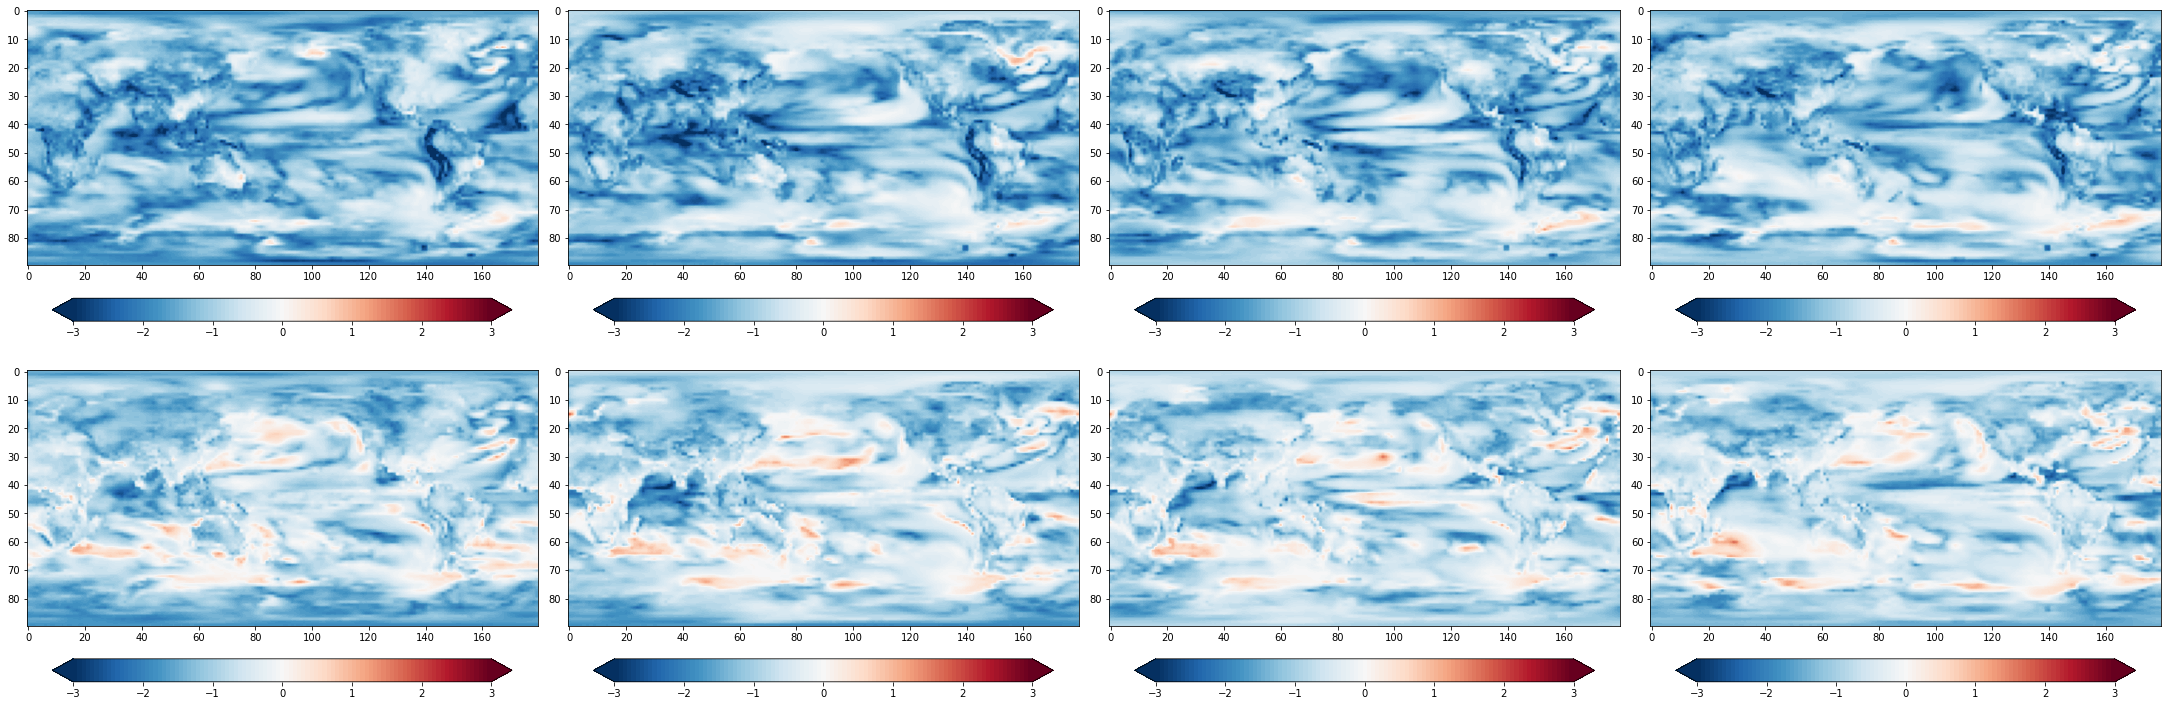

In [11]:
fig, ax = plt.subplots(2, 4, constrained_layout = True, figsize = (30, 10))


for j in range(4):
    cnf_imv_ratio = np.log(cnf[j]/imv[j])

    vcenter = 0
    vmin = -3
    vmax = 3
    cmap12 = plt.get_cmap('RdBu_r', 99)
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    im = ax[0,j].imshow(cnf_imv_ratio, cmap = cmap12, norm = divnorm)
    plt.colorbar(im, location = 'bottom', extend = 'both', shrink = 0.9)
    
for j in range(4):
    cnf_imv_ratio = np.log(cnf[j]/qce[j])

    vcenter = 0
    vmin = -3
    vmax = 3
    cmap12 = plt.get_cmap('RdBu_r', 99)
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    im = ax[1,j].imshow(cnf_imv_ratio, cmap = cmap12, norm = divnorm)
    plt.colorbar(im, location = 'bottom', extend = 'both', shrink = 0.9)

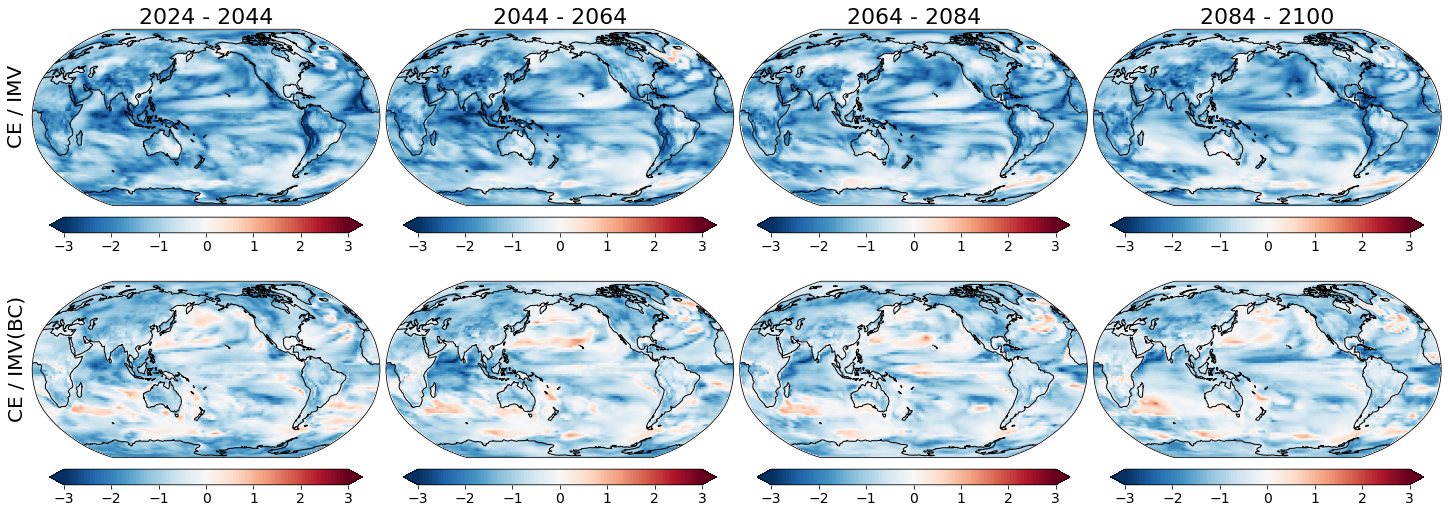

In [37]:
data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)

vcenter = 0
vmin = -3
vmax = 3
cmap12 = plt.get_cmap('RdBu_r', 99)
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

fig = plt.figure(constrained_layout = True, figsize = (20, 7))
gs = GridSpec(2, 5, width_ratios = [0.05, 1, 1, 1, 1], figure = fig)

# side labels
ax = plt.subplot(gs[0, 0])
ax.axis('off')
ax.text(0.0, 0.5, 'CE / IMV', fontsize=20, va='center', rotation='vertical')

ax = plt.subplot(gs[1, 0])
ax.axis('off')
ax.text(0.0, 0.5, 'CE / IMV(BC)', fontsize=20, va='center', rotation='vertical')

y1 = ['2024', '2044', '2064', '2084']
y2 = ['2044', '2064', '2084', '2100']

for j in range(4):
    ax = plt.subplot(gs[0, j+1], projection = plot_crs)
    cnf_imv_ratio = np.log(cnf[j]/imv[j])

    im = ax.imshow(cnf_imv_ratio, transform = data_crs, cmap = cmap12, norm = divnorm)
    ax.coastlines()
    cb = plt.colorbar(im, location = 'bottom', extend = 'both', shrink = 0.9)
    cb.ax.tick_params(labelsize = 14)
    
    ax.set_title(f'{y1[j]} - {y2[j]}', fontsize = 22)
    
for j in range(4):
    ax = plt.subplot(gs[1, j+1], projection = plot_crs)
    cnf_imv_ratio = np.log(cnf[j]/qce[j])

    im = ax.imshow(cnf_imv_ratio, transform = data_crs, cmap = cmap12, norm = divnorm)
    ax.coastlines()
    cb = plt.colorbar(im, location = 'bottom', extend = 'both', shrink = 0.9)
    cb.ax.tick_params(labelsize = 14)

In [41]:
restest.shape[0]//3

304

In [43]:
inc = restest.shape[0]//3

In [44]:
imv = np.array([vw2(imv_ens[(inc*i):(inc*(i+1))].reshape(-1, nlat, nlon), restest[(inc*i):(inc*(i+1))]) for i in range(3)])
qce = np.array([vw2(qc_ens[(inc*i):(inc*(i+1))].reshape(-1, nlat, nlon), restest[(inc*i):(inc*(i+1))]) for i in range(3)])
cnf = np.array([vw2(conf_ens1, restest[(inc*i):(inc*(i+1))]) for i in range(3)])

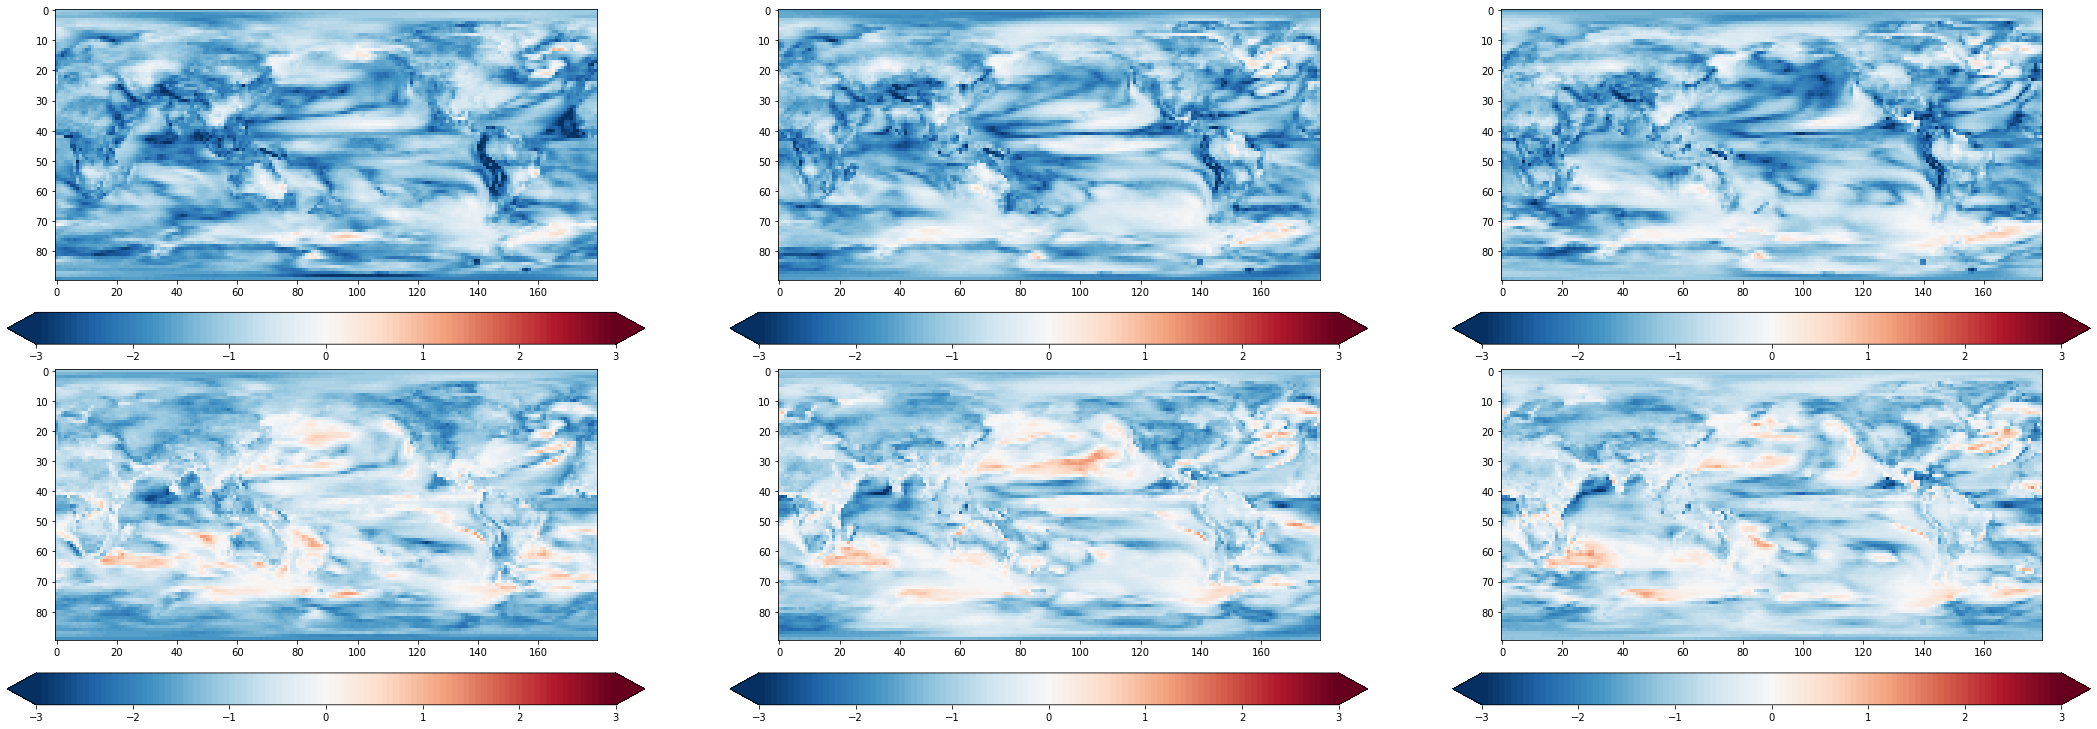

In [45]:
fig, ax = plt.subplots(2, 3, constrained_layout = True, figsize = (30, 10))


for j in range(3):
    cnf_imv_ratio = np.log(cnf[j]/imv[j])

    vcenter = 0
    vmin = -3
    vmax = 3
    cmap12 = plt.get_cmap('RdBu_r', 99)
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    im = ax[0,j].imshow(cnf_imv_ratio, cmap = cmap12, norm = divnorm)
    plt.colorbar(im, location = 'bottom', extend = 'both', shrink = 0.9)
    
for j in range(3):
    cnf_imv_ratio = np.log(cnf[j]/qce[j])

    vcenter = 0
    vmin = -3
    vmax = 3
    cmap12 = plt.get_cmap('RdBu_r', 99)
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    im = ax[1,j].imshow(cnf_imv_ratio, cmap = cmap12, norm = divnorm)
    plt.colorbar(im, location = 'bottom', extend = 'both', shrink = 0.9)

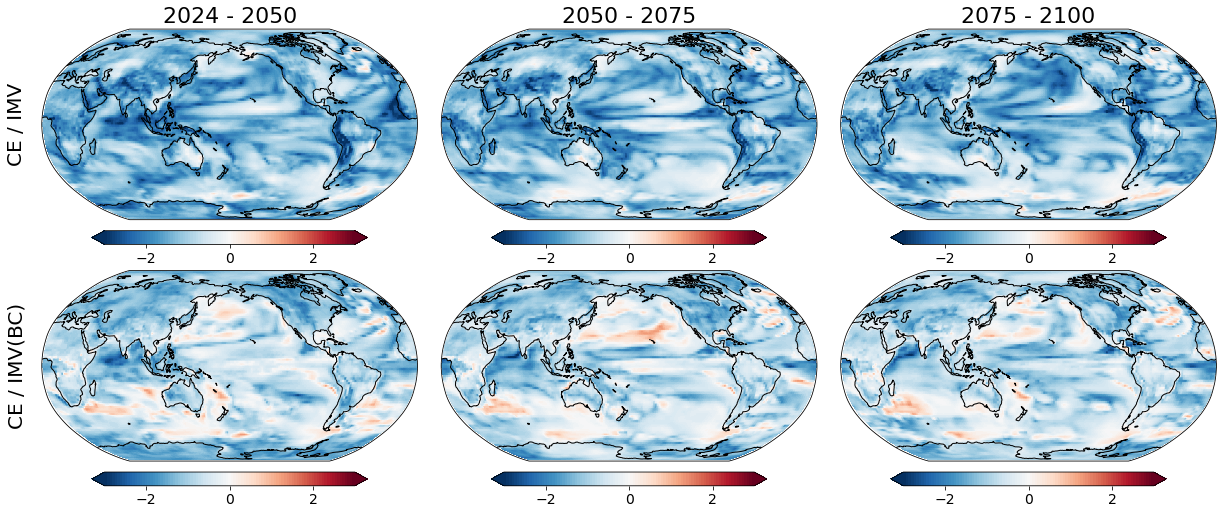

In [57]:
data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)

vcenter = 0
vmin = -3
vmax = 3
cmap12 = plt.get_cmap('RdBu_r', 99)
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

fig = plt.figure(constrained_layout = True, figsize = (17, 7))
gs = GridSpec(2, 4, width_ratios = [0.05, 1, 1, 1], figure = fig)

# side labels
ax = plt.subplot(gs[0, 0])
ax.axis('off')
ax.text(0.0, 0.5, 'CE / IMV', fontsize=20, va='center', rotation='vertical')

ax = plt.subplot(gs[1, 0])
ax.axis('off')
ax.text(0.0, 0.5, 'CE / IMV(BC)', fontsize=20, va='center', rotation='vertical')

y1 = ['2024', '2050', '2075']
y2 = ['2050', '2075', '2100']

for j in range(3):
    ax = plt.subplot(gs[0, j+1], projection = plot_crs)
    cnf_imv_ratio = np.log(cnf[j]/imv[j])

    im = ax.imshow(cnf_imv_ratio, transform = data_crs, cmap = cmap12, norm = divnorm)
    ax.coastlines()
    cb = plt.colorbar(im, location = 'bottom', extend = 'both', shrink = 0.7)
    cb.ax.tick_params(labelsize = 14)
    
    ax.set_title(f'{y1[j]} - {y2[j]}', fontsize = 22)
    
for j in range(3):
    ax = plt.subplot(gs[1, j+1], projection = plot_crs)
    cnf_imv_ratio = np.log(cnf[j]/qce[j])

    im = ax.imshow(cnf_imv_ratio, transform = data_crs, cmap = cmap12, norm = divnorm)
    ax.coastlines()
    cb = plt.colorbar(im, location = 'bottom', extend = 'both', shrink = 0.7)
    cb.ax.tick_params(labelsize = 14)

In [7]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_tas_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tas_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]
nlat, nlon = xhist_tas.shape[2:]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/tas'

alpha = 0.1
level = 1 - np.ceil((1 - alpha) * (nval + 1))/(nval + 1)

In [8]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
tas_results = np.zeros([nmod, nproj, 5, nlat, nlon])

np.random.seed(0)

for model_no in trange(nmod):
    xtrain, xval, xtest, ytrain, yval, ytest, xtrain_sd, xtest_sd = scale_and_split(xtrain_orig, xtest_orig, model_no = model_no, nval = nval)

    xval = xval * xtrain_sd[-nval:,None]
    xval = xval - np.mean(xval, axis = 1)[:,None]
    xtest = xtest * xtest_sd[:,None]
    imv_ens = xtest - np.mean(xtest, axis = 1)[:,None]

    xtest_qc = jnp.array([quantile_map(yval, xval[:,j], xtest[:,j], 20) for j in trange(1, nmod, leave = False)])
    xtest_qc = np.moveaxis(xtest_qc, 0, 1)
    qc_ens = xtest_qc - np.mean(xtest_qc, axis = 1)[:,None]
    
    ytest = ytest * xtest_sd
    yval = yval * xtrain_sd[-nval:]
    
    for k in range(0, nproj):
        
        yval_hat = np.load(save_loc + f'/yval_{analysis[k]}_{model_no}.npy')
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}_{model_no}.npy')
        
        if analysis[k] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)
            
        yval_hat = yval_hat.reshape(-1, nlat, nlon)
        ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
        
        yval_hat = yval_hat * xtrain_sd[-nval:]
        ytest_hat = ytest_hat * xtest_sd
        resval = (yval - yval_hat).reshape(-1, nlat, nlon)
        restest = (ytest - ytest_hat).reshape(-1, nlat, nlon)
        
        alpha = 0.1
        level = np.ceil((1 - alpha) * (nval + 1))/(nval + 1)
        dr1 = 1 - global_mmd_self(resval, resval)
        q = np.sort(dr1)[int(np.ceil((1 - alpha) * (nval + 1)))]
        q = (q + np.quantile(dr1, level))/2
        conf_ens1 = resval[dr1 < q]
        
        dr1 = 1 - tukey_depth_self(resval, resval)
        q = np.sort(dr1)[int(np.ceil((1 - alpha) * (nval + 1)))]
        q = (q + np.quantile(dr1, level))/2
        conf_ens2 = resval[dr1 < q]
        
        dr1 = 1 - inf_depth(resval)
        q = np.sort(dr1)[int(np.ceil((1 - alpha) * (nval + 1)))]
        q = (q + np.quantile(dr1, level))/2
        conf_ens3 = resval[dr1 < q]
        
        tas_results[model_no, k, 0] = vw2(imv_ens.reshape(-1, nlat, nlon), restest)
        tas_results[model_no, k, 1] = vw2(qc_ens.reshape(-1, nlat, nlon), restest)
        tas_results[model_no, k, 2] = vw2(conf_ens1, restest)
        tas_results[model_no, k, 3] = vw2(conf_ens2, restest)
        tas_results[model_no, k, 4] = vw2(conf_ens3, restest)
    

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [34]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_tasmax_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tasmax_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]
nlat, nlon = xhist_tas.shape[2:]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/tmax'

alpha = 0.1
level = 1 - np.ceil((1 - alpha) * (nval + 1))/(nval + 1)

In [35]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
tmax_results = np.zeros([nmod, nproj, 5, nlat, nlon])

np.random.seed(0)

for model_no in trange(nmod):
    xtrain, xval, xtest, ytrain, yval, ytest, xtrain_sd, xtest_sd = scale_and_split(xtrain_orig, xtest_orig, model_no = model_no, nval = nval)

    xval = xval * xtrain_sd[-nval:,None]
    xval = xval - np.mean(xval, axis = 1)[:,None]
    xtest = xtest * xtest_sd[:,None]
    imv_ens = xtest - np.mean(xtest, axis = 1)[:,None]

    xtest_qc = jnp.array([quantile_map(yval, xval[:,j], xtest[:,j], 20) for j in trange(1, nmod, leave = False)])
    xtest_qc = np.moveaxis(xtest_qc, 0, 1)
    qc_ens = xtest_qc - np.mean(xtest_qc, axis = 1)[:,None]
    
    ytest = ytest * xtest_sd
    yval = yval * xtrain_sd[-nval:]
    
    for k in range(0, nproj):
        
        yval_hat = np.load(save_loc + f'/yval_{analysis[k]}_{model_no}.npy')
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}_{model_no}.npy')
        
        if analysis[k] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)
            
        yval_hat = yval_hat.reshape(-1, nlat, nlon)
        ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
        
        yval_hat = yval_hat * xtrain_sd[-nval:]
        ytest_hat = ytest_hat * xtest_sd
        resval = (yval - yval_hat).reshape(-1, nlat, nlon)
        restest = (ytest - ytest_hat).reshape(-1, nlat, nlon)
        
        alpha = 0.1
        level = np.ceil((1 - alpha) * (nval + 1))/(nval + 1)
        dr1 = 1 - global_mmd_self(resval, resval)
        q = np.sort(dr1)[int(np.ceil((1 - alpha) * (nval + 1)))]
        q = (q + np.quantile(dr1, level))/2
        conf_ens1 = resval[dr1 < q]
        
        dr1 = 1 - tukey_depth_self(resval, resval)
        q = np.sort(dr1)[int(np.ceil((1 - alpha) * (nval + 1)))]
        q = (q + np.quantile(dr1, level))/2
        conf_ens2 = resval[dr1 < q]
        
        dr1 = 1 - inf_depth(resval)
        q = np.sort(dr1)[int(np.ceil((1 - alpha) * (nval + 1)))]
        q = (q + np.quantile(dr1, level))/2
        conf_ens3 = resval[dr1 < q]
        
        tmax_results[model_no, k, 0] = vw2(imv_ens.reshape(-1, nlat, nlon), restest)
        tmax_results[model_no, k, 1] = vw2(qc_ens.reshape(-1, nlat, nlon), restest)
        tmax_results[model_no, k, 2] = vw2(conf_ens1, restest)
        tmax_results[model_no, k, 3] = vw2(conf_ens2, restest)
        tmax_results[model_no, k, 4] = vw2(conf_ens3, restest)
    

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [36]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_pr_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_pr_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]
nlat, nlon = xhist_tas[0].shape[1:]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

xtrain_orig = np.log(np.abs(xtrain_orig) + 1e-3)
xtest_orig = np.log(np.abs(xtest_orig) + 1e-3)

xtrain_orig = np.float32(xtrain_orig)
xtest_orig = np.float32(xtest_orig)

save_loc = 'trained_models/pr'

In [37]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
pr_results = np.zeros([nmod, nproj, 5, nlat, nlon])

np.random.seed(0)

for model_no in trange(nmod):
    xtrain, xval, xtest, ytrain, yval, ytest, xtrain_sd, xtest_sd = scale_and_split(xtrain_orig, xtest_orig, model_no = model_no, nval = nval)

    xval = xval * xtrain_sd[-nval:,None]
    xval = xval - np.mean(xval, axis = 1)[:,None]
    xtest = xtest * xtest_sd[:,None]
    imv_ens = xtest - np.mean(xtest, axis = 1)[:,None]

    xtest_qc = jnp.array([quantile_map(yval, xval[:,j], xtest[:,j], 20) for j in trange(1, nmod, leave = False)])
    xtest_qc = np.moveaxis(xtest_qc, 0, 1)
    qc_ens = xtest_qc - np.mean(xtest_qc, axis = 1)[:,None]
    
    ytest = ytest * xtest_sd
    yval = yval * xtrain_sd[-nval:]
    
    for k in range(0, nproj):
        
        yval_hat = np.load(save_loc + f'/yval_{analysis[k]}_{model_no}.npy')
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}_{model_no}.npy')
        
        if analysis[k] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)
            
        yval_hat = yval_hat.reshape(-1, nlat, nlon)
        ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
        
        yval_hat = yval_hat * xtrain_sd[-nval:]
        ytest_hat = ytest_hat * xtest_sd
        resval = (yval - yval_hat).reshape(-1, nlat, nlon)
        restest = (ytest - ytest_hat).reshape(-1, nlat, nlon)
        
        alpha = 0.1
        level = np.ceil((1 - alpha) * (nval + 1))/(nval + 1)
        dr1 = 1 - global_mmd_self(resval, resval)
        q = np.sort(dr1)[int(np.ceil((1 - alpha) * (nval + 1)))]
        q = (q + np.quantile(dr1, level))/2
        conf_ens1 = resval[dr1 < q]
        
        dr1 = 1 - tukey_depth_self(resval, resval)
        q = np.sort(dr1)[int(np.ceil((1 - alpha) * (nval + 1)))]
        q = (q + np.quantile(dr1, level))/2
        conf_ens2 = resval[dr1 < q]
        
        dr1 = 1 - inf_depth(resval)
        q = np.sort(dr1)[int(np.ceil((1 - alpha) * (nval + 1)))]
        q = (q + np.quantile(dr1, level))/2
        conf_ens3 = resval[dr1 < q]
        
        pr_results[model_no, k, 0] = vw2(imv_ens.reshape(-1, nlat, nlon), restest)
        pr_results[model_no, k, 1] = vw2(qc_ens.reshape(-1, nlat, nlon), restest)
        pr_results[model_no, k, 2] = vw2(conf_ens1, restest)
        pr_results[model_no, k, 3] = vw2(conf_ens2, restest)
        pr_results[model_no, k, 4] = vw2(conf_ens3, restest)
    

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

In [38]:
tas_mu = np.mean(np.median(tas_results, axis = 1), axis = 0)
tmax_mu = np.mean(np.median(tmax_results, axis = 1), axis = 0)
pr_mu = np.mean(np.median(pr_results, axis = 1), axis = 0)

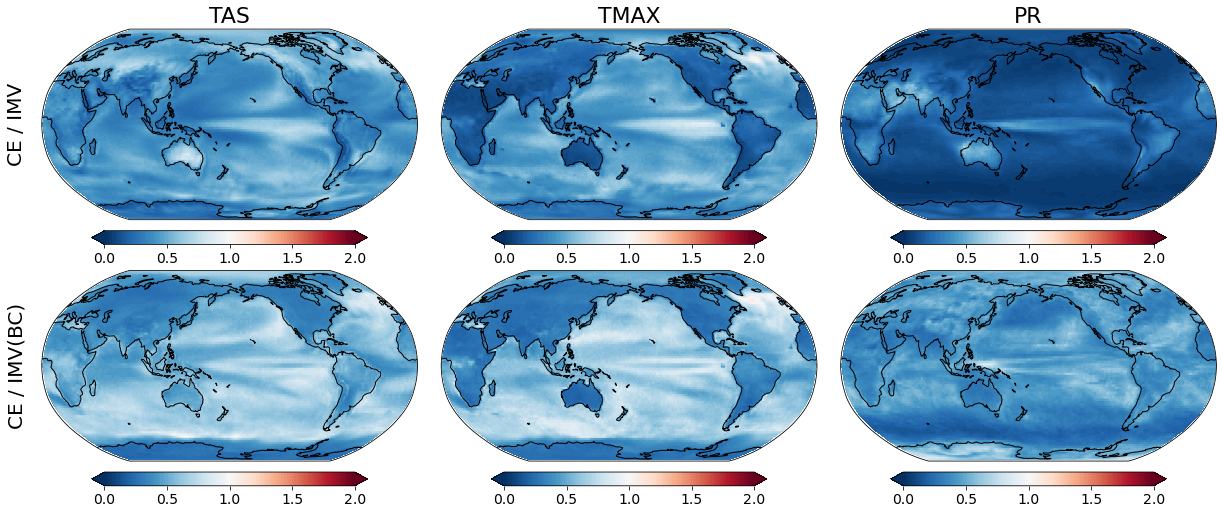

In [49]:
data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)

vcenter = 1
vmin = 0
vmax = 2
cmap12 = plt.get_cmap('RdBu_r', 99)
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

tas_mu = np.mean(np.median(tas_results, axis = 1), axis = 0)
tmax_mu = np.mean(np.median(tmax_results, axis = 1), axis = 0)
pr_mu = np.mean(np.median(pr_results, axis = 1), axis = 0)
clim_mu = [tas_mu, tmax_mu, pr_mu]

fig = plt.figure(constrained_layout = True, figsize = (17, 7))
gs = GridSpec(2, 4, width_ratios = [0.05, 1, 1, 1], figure = fig)

# side labels
ax = plt.subplot(gs[0, 0])
ax.axis('off')
ax.text(0.0, 0.5, 'CE / IMV', fontsize=20, va='center', rotation='vertical')

ax = plt.subplot(gs[1, 0])
ax.axis('off')
ax.text(0.0, 0.5, 'CE / IMV(BC)', fontsize=20, va='center', rotation='vertical')

# titles
clim_var = ['TAS', 'TMAX', 'PR']

for j in range(3):
    ax = plt.subplot(gs[0, j+1], projection = plot_crs)
    cnf_imv_ratio = clim_mu[j][2]/clim_mu[j][0]

    im = ax.imshow(cnf_imv_ratio, transform = data_crs, cmap = cmap12, norm = divnorm)
    ax.coastlines()
    cb = plt.colorbar(im, location = 'bottom', extend = 'both', shrink = 0.7)
    cb.ax.tick_params(labelsize = 14)
    
    ax.set_title(f'{clim_var[j]}', fontsize = 22)
    
for j in range(3):
    ax = plt.subplot(gs[1, j+1], projection = plot_crs)
    cnf_imv_ratio = clim_mu[j][2]/clim_mu[j][1]

    im = ax.imshow(cnf_imv_ratio, transform = data_crs, cmap = cmap12, norm = divnorm)
    ax.coastlines()
    cb = plt.colorbar(im, location = 'bottom', extend = 'both', shrink = 0.7)
    cb.ax.tick_params(labelsize = 14)
    

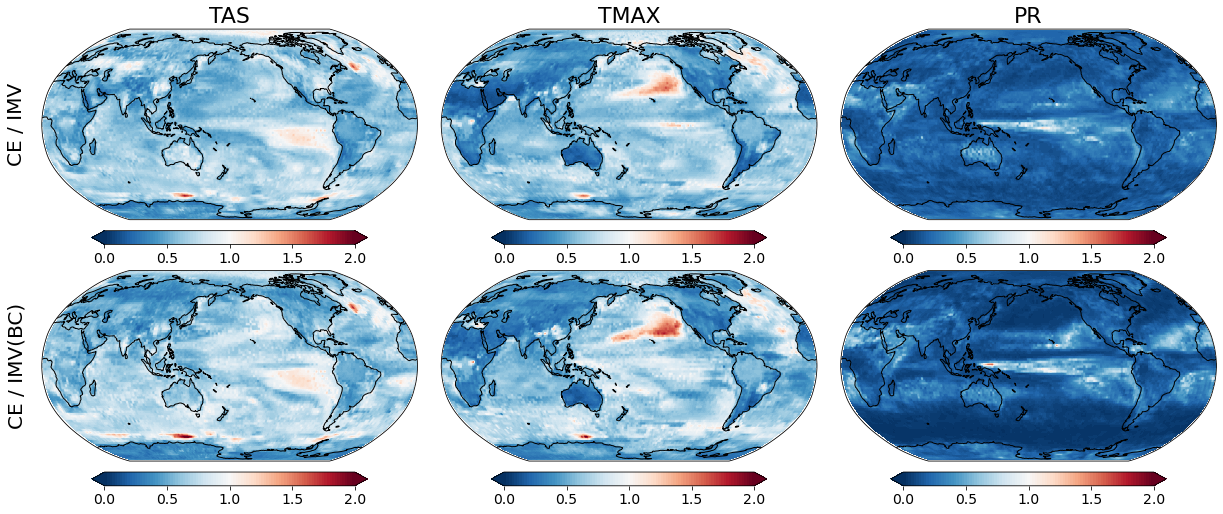

In [50]:
data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)

vcenter = 1
vmin = 0
vmax = 2
cmap12 = plt.get_cmap('RdBu_r', 99)
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

tas_max = np.max(np.median(tas_results, axis = 1), axis = 0)
tmax_max = np.max(np.median(tmax_results, axis = 1), axis = 0)
pr_max = np.max(np.median(pr_results, axis = 1), axis = 0)
clim_max = [tas_max, tmax_max, pr_max]

fig = plt.figure(constrained_layout = True, figsize = (17, 7))
gs = GridSpec(2, 4, width_ratios = [0.05, 1, 1, 1], figure = fig)

# side labels
ax = plt.subplot(gs[0, 0])
ax.axis('off')
ax.text(0.0, 0.5, 'CE / IMV', fontsize=20, va='center', rotation='vertical')

ax = plt.subplot(gs[1, 0])
ax.axis('off')
ax.text(0.0, 0.5, 'CE / IMV(BC)', fontsize=20, va='center', rotation='vertical')

# titles
clim_var = ['TAS', 'TMAX', 'PR']
    
for j in range(3):
    ax = plt.subplot(gs[0, j+1], projection = plot_crs)
    cnf_imv_ratio = clim_max[j][2]/clim_max[j][0]

    im = ax.imshow(cnf_imv_ratio, transform = data_crs, cmap = cmap12, norm = divnorm)
    ax.coastlines()
    cb = plt.colorbar(im, location = 'bottom', extend = 'both', shrink = 0.7)
    cb.ax.tick_params(labelsize = 14)
    
    ax.set_title(f'{clim_var[j]}', fontsize = 22)
    
for j in range(3):
    ax = plt.subplot(gs[1, j+1], projection = plot_crs)
    cnf_imv_ratio = clim_max[j][2]/clim_max[j][1]

    im = ax.imshow(cnf_imv_ratio, transform = data_crs, cmap = cmap12, norm = divnorm)
    ax.coastlines()
    cb = plt.colorbar(im, location = 'bottom', extend = 'both', shrink = 0.7)
    cb.ax.tick_params(labelsize = 14)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))

ts = np.arange(8)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

tas_mu = np.median(tas_results, axis = 1)
tmax_mu = np.median(tmax_results, axis = 1)
pr_mu = np.median(pr_results, axis = 1)

tas_sd = 2 * np.std(tas_mu, axis = 0).T / np.sqrt(tas_mu.shape[0])
tmax_sd = 2 * np.std(tmax_mu, axis = 0).T / np.sqrt(tmax_mu.shape[0])
pr_sd = 2 * np.std(pr_mu, axis = 0).T / np.sqrt(pr_mu.shape[0])
tas_sd = tas_sd[:,:3]
tmax_sd = tmax_sd[:,:3]
pr_sd = pr_sd[:,:3]

tas_mu = np.mean(tas_mu, axis = 0).T
tmax_mu = np.mean(tmax_mu, axis = 0).T
pr_mu = np.mean(pr_mu, axis = 0).T

cols = ['C0', 'C1', 'C3']

# labeling
ax[0].set_title('TAS', fontsize = 18)
ax[1].set_title('TMAX', fontsize = 18)
ax[2].set_title('PR', fontsize = 18)

ax[2].plot([], [], c = cols[0], label = 'IMV')
ax[2].plot([], [], c = cols[1], label = 'IMV(BC)')
ax[2].plot([], [], c = cols[2], label = 'Conf.')

ax[0].set_ylabel('SW', fontsize = 20)

for i in range(3):
    ax[0].plot(tas_mu[:,i], c = cols[i], marker = 'o')
    ax[0].fill_between(ts, tas_mu[:,i] + tas_sd[:,i], tas_mu[:,i] - tas_sd[:,i], alpha = 0.2, color = cols[i])
    
    ax[1].plot(tmax_mu[:,i], c = cols[i], marker = 'o')
    ax[1].fill_between(ts, tmax_mu[:,i] + tmax_sd[:,i], tmax_mu[:,i] - tmax_sd[:,i], alpha = 0.2, color = cols[i])
    
    ax[2].plot(pr_mu[:,i], c = cols[i], marker = 'o')
    ax[2].fill_between(ts, pr_mu[:,i] + pr_sd[:,i], pr_mu[:,i] - pr_sd[:,i], alpha = 0.2, color = cols[i])
    
    ax[i].yaxis.set_major_formatter('{x:0<3.1f}')
    ax[i].xaxis.set_major_formatter('{x:0<3.2f}')
    ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].set_xticks(ts, 2030 + 10 * ts, fontsize = 16, rotation=45)
ax[2].legend(loc = 'right', fontsize = 15)
plt.show()